In [ ]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip.ref.extractall('./')

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [ ]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [4]:
print(data.info())
print(f'\n\nCheck if any nulls \n{data.isnull().sum()}')
print(f'\n\nSummary data statistics \n{data.describe()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None


Check if any nulls 
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Summary data statistics 
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000    

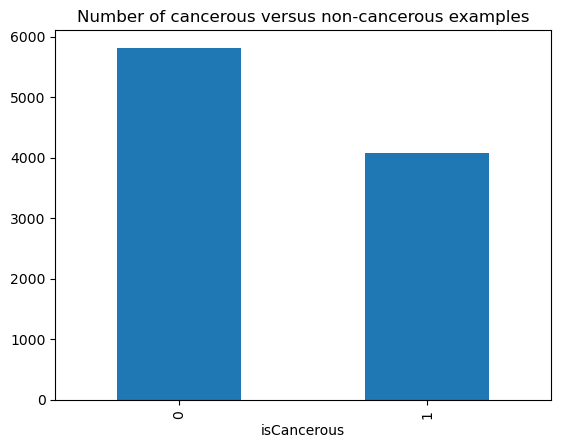

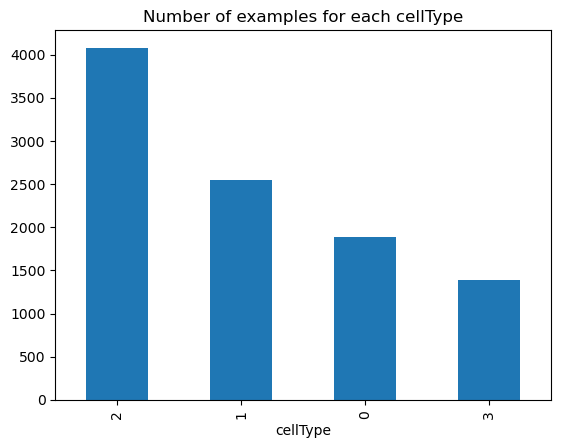

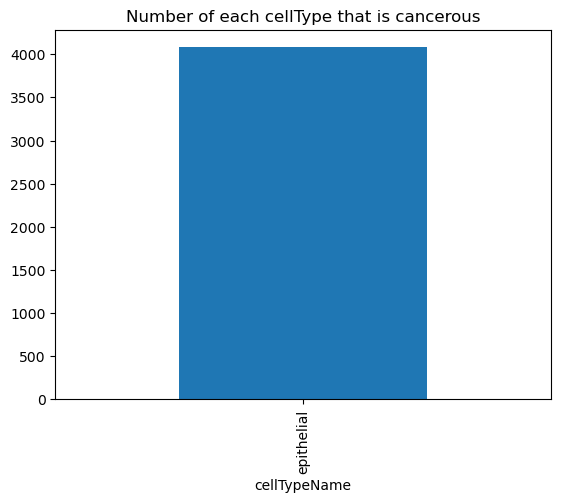

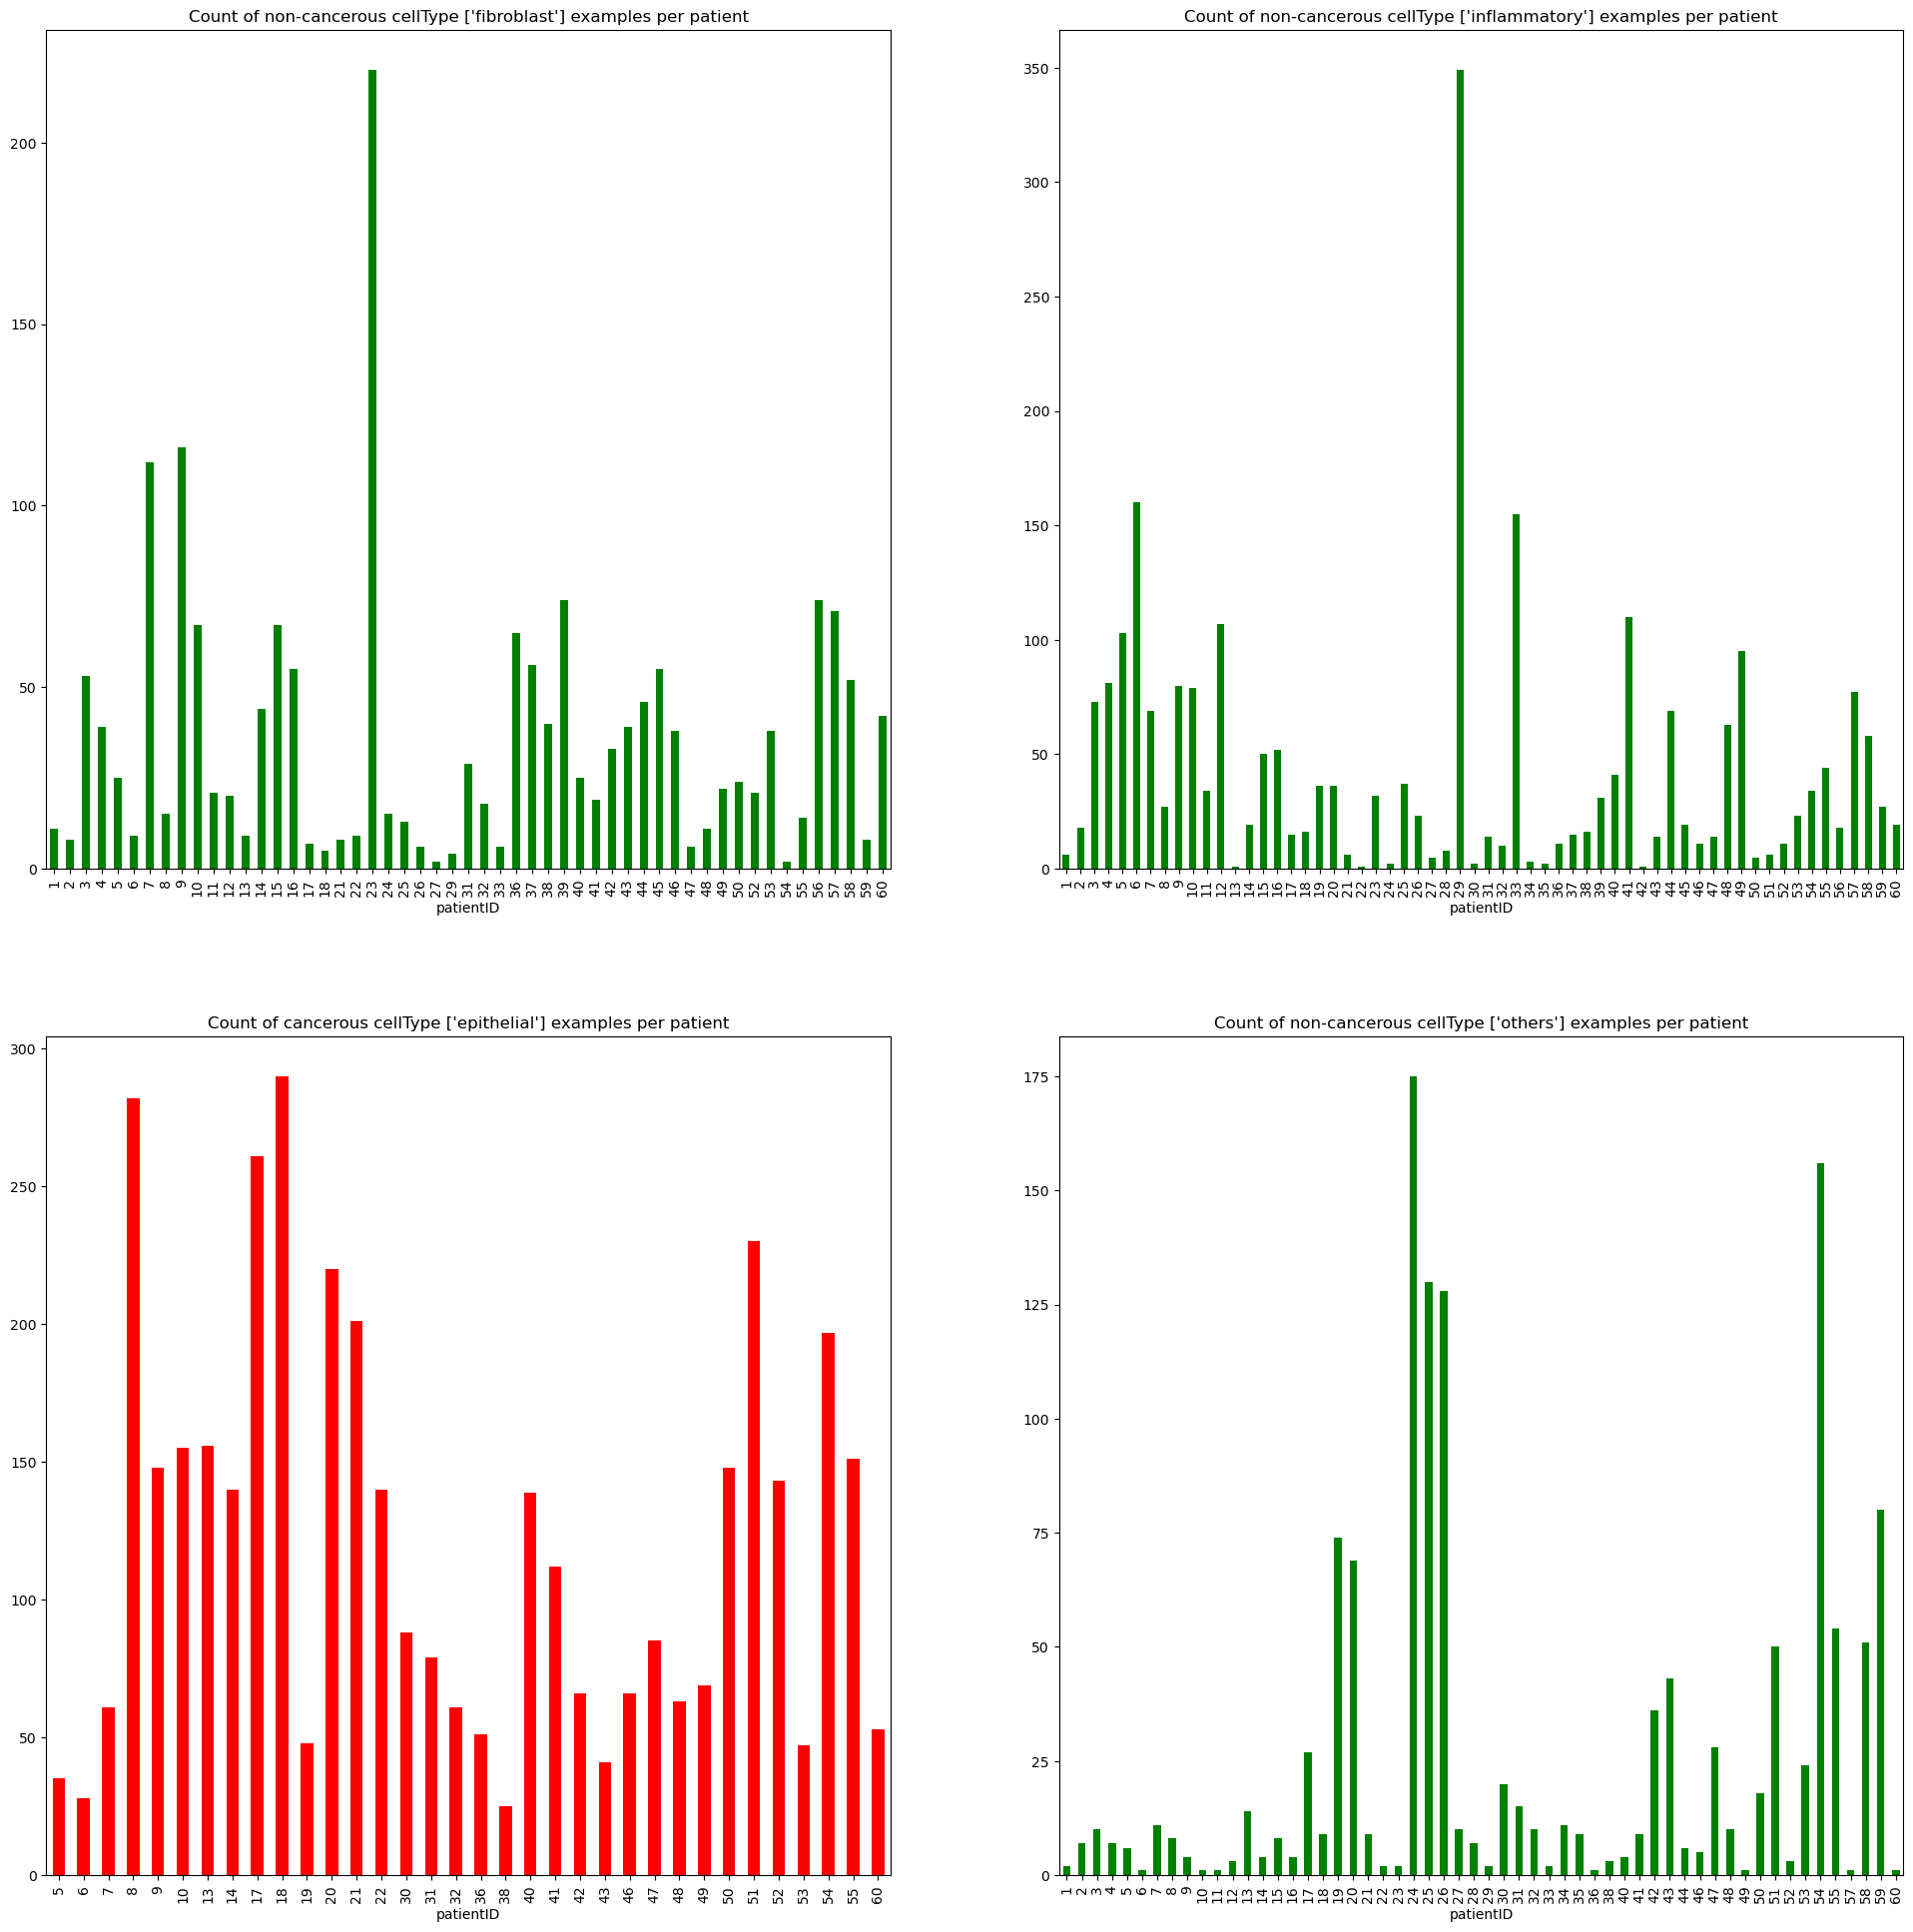

In [145]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
# from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray


data['isCancerous'].value_counts().plot(kind='bar', title='Number of cancerous versus non-cancerous examples')
plt.show()
data['cellType'].value_counts().plot(kind='bar', title='Number of examples for each cellType')
plt.show()
data[data['isCancerous'] == 1]['cellTypeName'].value_counts().plot(kind='bar', title='Number of each cellType that is cancerous')
plt.show()



plt.figure(figsize=(24, 24))
for i in range(0, 4):
    plt.subplot(2, 2, i + 1)
    # Get rows where cellType = i and get value count of each patientID (how many patients have that cellType)
    byCellTypeCountCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 1)]['patientID'].value_counts().sort_index()
    byCellTypeCountNotCancerous = data[(data['cellType'] == i) & (data['isCancerous'] == 0)]['patientID'].value_counts().sort_index()
    if len(byCellTypeCountCancerous) > 0: 
        byCellTypeCountCancerous.plot(kind='bar', color='red', title=f'Count of cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    if len(byCellTypeCountNotCancerous) > 0:
        byCellTypeCountNotCancerous.plot(kind='bar', label='isCancerous = 0', color='green', title=f'Count of non-cancerous cellType {data[data['cellType'] == i]['cellTypeName'].unique()} examples per patient')
    
plt.show()

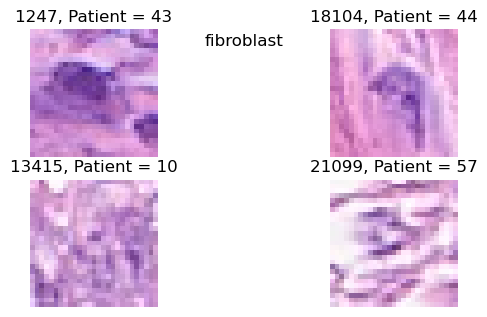

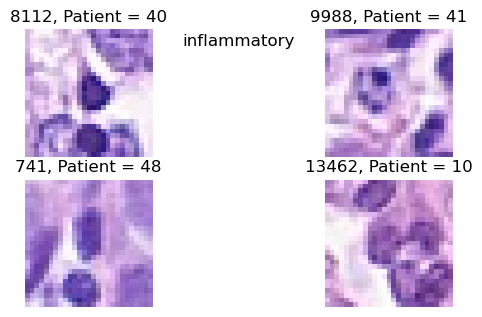

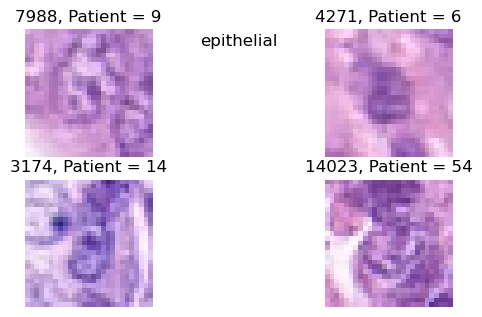

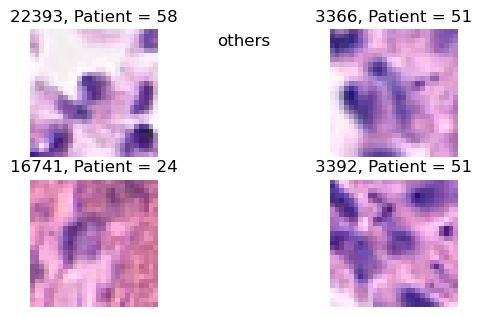

In [148]:
import math


celltype_dict = {}
for cell in data['cellType'].unique():
    celltype_dict[cell] = data[data['cellType'] == cell]


for i in range (len(celltype_dict)):
    celltype = celltype_dict[i]
    num = 8
    col = 2
    row = math.ceil(num/col)
    plt.figure(figsize=(col * 3, row * 3))
    sample = celltype.sample(n=4)
    for j in range(len(sample)):
        image_path = sample.iloc[j]['ImageName']
        im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=False, plugin=None)
        plt.subplot(num, col, j + 1)
        plt.title(f'{sample.iloc[j]['InstanceID']}, Patient = {sample.iloc[j]['patientID']}')
        plt.imshow(im, cmap=plt.cm.gray)
        plt.axis('off')
    plt.tight_layout(pad=0.0, h_pad=0.2, w_pad=0.0)
    plt.suptitle(sample.iloc[1]['cellTypeName'])
    plt.show()
        

In [ ]:
# F1 Score



In [167]:
# Data splitting

patient_dict = {}
for id  in data['patientID'].unique():
    patient_dict[id] = data[data['patientID'] == id]

patients_groupByCancerous = {}
patients_groupByNonCancerous = {}
for id, value in patient_dict.items():
    if patient_dict[id]['isCancerous'].eq(1).any():
        patients_groupByCancerous[id] = value
    else:
        patients_groupByNonCancerous[id] = value

print(f'Total number of patients is: {len(patients_groupByCancerous) + len(patients_groupByNonCancerous)}')
print(f'With {len(patients_groupByCancerous)} patients with a cancerous cell versus {len(patients_groupByNonCancerous)} patients with no cancerous cells')

# cancerousExamples = data[data['isCancerous'] == 1]
# nonCancerousExamples = data[data['isCancerous'] == 0]

# cancerousExamples_groupbypatient = {}
# for id in cancerousExamples['patientID'].unique():
#     cancerousExamples_groupbypatient[id] = cancerousExamples[cancerousExamples['patientID'] == id]

# nonCancerousExamples_groupbypatient = {}
# for id in nonCancerousExamples['patientID'].unique():
#     nonCancerousExamples_groupbypatient[id] = nonCancerousExamples[nonCancerousExamples['patientID'] == id]

TRAIN_SPLIT_PERCENT = 0.80
VALID_SPLIT_PERCENT = 0.20
TEST_SPLIT_PERCENT = 0.80
TOTAL_IMAGES = len(data)
RATIO = len(data[data['isCancerous'] == 1]) / TOTAL_IMAGES

train = pd.DataFrame(columns=data.columns)
test = pd.DataFrame(columns=data.columns)
val = pd.DataFrame(columns=data.columns)

# Pick random patients from canerous and non cancerous group 
train_split_Cancerous_keys = pd.DataFrame(list(patients_groupByCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
train_split_nonCancerous_keys = pd.DataFrame(list(patients_groupByNonCancerous.keys()), columns=['patientID']).sample(frac=TRAIN_SPLIT_PERCENT, random_state=10).reset_index(drop=True)

# From the train set pick random patients for val set
val_split_Cancerous_keys = train_split_Cancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)
val_split_nonCancerous_keys = train_split_nonCancerous_keys.sample(frac=VALID_SPLIT_PERCENT, random_state=10).reset_index(drop=True)


print(f'- For train set, picked {len(train_split_Cancerous_keys)} patients out of {len(patients_groupByCancerous)} patients with cancerous cells')
# print(f'They are \n {train_split_Cancerous_keys}')
print(f'- For train set, picked {len(train_split_nonCancerous_keys)} patients out of {len(patients_groupByNonCancerous)} patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patients in train set of {len(train_split_Cancerous_keys)/(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys))} ')
print(f'- Therefore, there is a ratio of cancerous to total patients in test set of {(len(train_split_Cancerous_keys ) - len(patients_groupByCancerous)) /(len(train_split_nonCancerous_keys) + len(train_split_Cancerous_keys) - (len(patients_groupByNonCancerous) + len(patients_groupByCancerous)))} ')

print(f'- For val set, picked {len(val_split_Cancerous_keys)} patients out of {len(train_split_Cancerous_keys)} train set patients with cancerous cells')
print(f'- For val set, picked {len(val_split_nonCancerous_keys)} patients out of {len(train_split_nonCancerous_keys)} train set patients with non cancerous cells')
print(f'- Therefore, there is a ratio of cancerous to total patient in val set of {len(val_split_Cancerous_keys)/(len(val_split_Cancerous_keys) + len(val_split_nonCancerous_keys))}')

# Now based on picks for train set place the patients in the train set otherwise in the test set.
for id, key in patients_groupByCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_Cancerous_keys['patientID'].eq(id).any():
        train = pd.concat([train, patients_groupByCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByCancerous[id]], ignore_index=True)

for id, key in patients_groupByNonCancerous.items():
    # If key of patient is selected for train then place it in the train set else in the test set
    if train_split_nonCancerous_keys['patientID'].eq(id).any():
        train = pd.concat([train, patients_groupByNonCancerous[id]], ignore_index=True)
    else:
        test = pd.concat([test, patients_groupByNonCancerous[id]], ignore_index=True)

print(f'- There is {len(train['patientID'].unique())} patients in the train set. The count for each cell type is:\n{train['cellType'].value_counts()}')
print(f'- There is {len(test['patientID'].unique())} patients in the test set. The count for each cell type is:\n{test['cellType'].value_counts()}')
print(f'- Therefore, ratio of train to total is: {len(train)/ len(data)} versus the ratio of test to total: {len(test)/len(data)}') 

print(f'- The value counts for isCancerous for train set is:\n{train['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for test set is:\n{test['isCancerous'].value_counts()}')
print(f'- The value counts for isCancerous for whole data set is:\n{data['isCancerous'].value_counts()}')


# I could make the splitter above modular but cannot be bothered for

Total number of patients is: 60
With 34 patients with a cancerous cell versus 26 patients with no cancerous cells
- For train set, picked 27 patients out of 34 patients with cancerous cells
- For train set, picked 21 patients out of 26 patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patients in train set of 0.5625 
- Therefore, there is a ratio of cancerous to total patients in test set of 0.5833333333333334 
- For val set, picked 5 patients out of 27 train set patients with cancerous cells
- For val set, picked 4 patients out of 21 train set patients with non cancerous cells
- Therefore, there is a ratio of cancerous to total patient in val set of 0.5555555555555556
- There is 48 patients in the train set. The count for each cell type is:
cellType
2    3183
1    2126
0    1676
3    1088
Name: count, dtype: int64
- There is 12 patients in the test set. The count for each cell type is:
cellType
2    896
1    417
3    298
0    212
Name: count, dtype:

In [ ]:
# Data generator + Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

OUTPUT_CLASSES_CELLTYPE = 4

# For some reason ImageDataGenerator needs classes to be strings
train['cellType'] = train['cellType'].astype(str)


# Lets do bit of normalisation with pixel values -> faster training
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# A hyperparameter?
batch_size = 32

train_generator = train_datagen.flow_from_datagram(
    dataframe = train,
    directory = './patch_images/',
    x_col = 'ImageName',
    y_col = 'celltype'
    target_size=(32, 32),
    batch_size = batch_size,
    class_mode = 'categorical'
)


In [ ]:
# Model Development

import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

0        4083.png
1        4084.png
2        4085.png
3        4086.png
4        4087.png
          ...    
8068    17819.png
8069    17820.png
8070    17821.png
8071    17822.png
8072    17823.png
Name: ImageName, Length: 8073, dtype: object

In [ ]:
# Appendix



# Plot of images related to each patient

# for i in range(0, 3):
#     patient = patient_dict[i]
#     num = len(patient)
#     col = 5
#     row = math.ceil(num/col)
#     plt.figure(figsize=(col * 4, row * 4))
#     for j in range(0, len(patient)):
#         # print(j)
#         image_path = patient.iloc[j]['ImageName']
#         # print(image_path)
#         im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=True, plugin=None)
#         # print('yes')
#         plt.subplot(num, col, j + 1)
#         plt.title(f'{patient.iloc[j]['InstanceID']}, Cell = {patient.iloc[j]['cellTypeName']}')
#         plt.imshow(im, cmap=plt.cm.gray)
#         plt.axis('off')
#     plt.tight_layout(pad=0.5, h_pad=0.2, w_pad=0.2)
#     plt.show()

   